In [126]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
import tensorflow as tf
from scripts.iab import AttPredictorPecNet, AttPredictorPecNetWithType, AttPredictorPecNetWithTypeD3
from scripts.visualize import vis_cur_and_fut
from scripts.config import build_parser
from scripts.dataloaders import context_description, CustomImageDataset, d_collate_fn
from scripts.rgb_loader import RgbLoader

tf.get_logger().setLevel('ERROR')

import torch

from tqdm.auto import tqdm
import torch.utils.data

import matplotlib.pyplot as plt
import numpy as np
import wandb
import random
from scripts.train import preprocess_batch, apply_tr, get_future

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

import os

In [187]:
batch_size = 5

train_tfrecord_path = os.path.join("/home/jovyan/uncompressed/tf_example", "training/training_tfexample.*-of-01000")

train_dataset = CustomImageDataset(train_tfrecord_path, context_description)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=0, collate_fn=d_collate_fn)


test_path = os.path.join("/home/jovyan/uncompressed/tf_example", "validation/validation_tfexample.tfrecord-*-of-00150")
test_dataset = CustomImageDataset(test_path, context_description)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          num_workers=0, collate_fn=d_collate_fn)

train dataset containing 479 files
train dataset containing 150 files


In [2]:
device = "cuda"

net = AttPredictorPecNetWithType(inp_dim=1024, embed_dim=256, num_blocks=4,
                         out_modes=6, use_vis=1, use_rec=0,
                         use_points=0, out_horiz=80)
# net = torch.nn.DataParallel(net, [2])
net = torch.nn.DataParallel(net)
net.load_state_dict(
    torch.load("/home/jovyan/waymo-open-dataset/tutorial/checkpoints/model-seed-0-epoch-0.pt", map_location="cuda"))

net = net.to(device)

net.eval()
pass

train dataset containing 479 files
loaded index file contains 6806.0 indexes to files


In [ ]:
net_old = AttPredictorPecNet(inp_dim=1024, embed_dim=256, num_blocks=4,
                         out_modes=6, use_vis=1, use_rec=0,
                         use_points=0, out_horiz=80)
net_old = torch.nn.DataParallel(net_old)

In [ ]:
# net_old

In [ ]:
net_old.load_state_dict(
    torch.load("/home/jovyan/waymo-open-dataset/tutorial/checkpoints/model-seed-0-epoch-4.pt", map_location="cuda"))

net_old = net_old.to(device)
net_old.eval()


pass

In [ ]:
iter_loader = iter(train_loader)

In [3]:
train_index_path = "./rendered/train/index.pkl"
train_rgb_loader = RgbLoader(train_index_path)

val_index_path = "./rendered/val/index.pkl"
val_rgb_loader = RgbLoader(val_index_path)


loaded index file contains 6806.0 indexes to files
loaded index file contains 1234.0 indexes to files


In [ ]:
counter = 0
for i in tqdm(range(200)):
    with torch.no_grad():
        # use tqdm to iterate data
        data = next(iter_loader)
        # add rgb to data
        data["rgbs"] = torch.tensor(rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32))
        # preprocess_batch
        data_pr = preprocess_batch(data, net.module.use_points, net.module.use_vis)
        # get predictionswell
        poses, confs, goals_local, rot_mat, rot_mat_inv = net(data_pr)
        poses = apply_tr(poses, rot_mat_inv)
        image = vis_cur_and_fut(data, poses.detach().cpu(), confs=confs.detach().cpu())

        poses1, confs1, goals_local1, rot_mat1, rot_mat_inv1 = net_old(data_pr)
        poses1 = apply_tr(poses1, rot_mat_inv1)
        image1 = vis_cur_and_fut(data, poses1.detach().cpu(), confs=confs1.detach().cpu())
        # visualize
        # create plt fipure with 2 subplots
        fig, ax = plt.subplots(2, 1, figsize=(30, 30))
        # plot the first subplot
        ax[0].imshow(image)
        ax[0].set_title('new model AttPredictorPecNetWithType, 27.04')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # plot the second subplot
        ax[1].imshow(image1)
        ax[1].set_title('old model AttPredictorPecNet, 26.04')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        # save the figure
        # fig.show()
        plt.savefig(f'comparison/test{counter}.png', dpi=300)
        counter+=1
        plt.close()


confidences not very expressive 


!!!stationary object not oriented


types of objects is imp as well

goals often not alligned (even though path is ok)

In [190]:
train_iter_loader = iter(train_loader)
test_iter_loader = iter(test_loader)

In [264]:
test_mean_poses = []
train_mean_poses = []
for i in tqdm(range(1_0)):
    train_data = next(train_iter_loader)
    test_data =next(test_iter_loader)
    test_batch_unpacked = preprocess_batch(test_data, 0, 0)
    train_batch_unpacked = preprocess_batch(train_data, 0, 0)
    test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
    train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
    
    train_last_pose = train_state_masked[:, :, :2]#[mask>0]
    trlp_valid = train_last_pose[train_masks.flip(-1)>0]#[train_masks[:,-1]>0]
    
    # masks = test_data["state/tracks_to_predict"]
    test_masks = test_data['state/past/valid'].reshape(-1,128,10)[masks>0]
    test_last_pose = test_state_masked[:, :, :2]
    telp_valid = test_last_pose[test_masks.flip(-1)>0]
    # print(telp_valid.shape)
    train_mean_poses.append(trlp_valid.mean([0]))
    test_mean_poses.append(telp_valid.mean([0]))
print(torch.stack(train_mean_poses).mean(0))
print(torch.stack(test_mean_poses).mean(0))

  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: The shape of the mask [5, 128] at index 0 does not match the shape of the indexed tensor [22, 11, 2] at index 0

In [267]:
test_masks

tensor([[ True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [217]:
test_mean_poses

[tensor([-0.57, -2.29], device='cuda:0'),
 tensor([-85.06, 129.36], device='cuda:0'),
 tensor([-0.02, -4.59], device='cuda:0'),
 tensor([-8.79, 25.16], device='cuda:0'),
 tensor([-390.62, -319.01], device='cuda:0'),
 tensor([-240.77,  265.96], device='cuda:0'),
 tensor([  69.76, -135.97], device='cuda:0'),
 tensor([ -49.86, -457.49], device='cuda:0'),
 tensor([450.44, 150.50], device='cuda:0'),
 tensor([  4.14, 213.86], device='cuda:0')]

In [135]:
def get_local_fut_path(data):
    batch_unpacked = preprocess_batch(data, 0, 0)
    _, rot_mat, _, _, _, _  = batch_unpacked
    # train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
    use_every_nth_prediction = 1
    mask = data["state/tracks_to_predict"]
    fut_path = get_future(data).to("cuda").permute(0, 2, 1, 3)[mask > 0]

    fut_ext = torch.cat([fut_path, torch.ones_like(fut_path[:, :, :1])], -1)
    fut_path = torch.bmm(rot_mat, fut_ext.permute(0, 2, 1)).permute(0, 2, 1)[:,
               use_every_nth_prediction - 1::use_every_nth_prediction, :2]
    return fut_path

In [165]:
mask = train_data["state/tracks_to_predict"]
train_data['state/future/valid'].reshape(-1,128,80)[mask>0].shape


torch.Size([29, 80])

In [11]:
test_data["rgbs"].shape

torch.Size([5, 224, 224, 3])

In [90]:
torch.stack([train_state_masked[:,:,:2].mean((0,1)), train_state_masked[:,:,:2].mean((0,1))]).mean(0)

tensor([-0.0054, -2.7951], device='cuda:0')

In [114]:
train_data["rgbs"] = torch.tensor(train_rgb_loader.load_batch_rgb(train_data, prefix="").astype(np.float32))
test_data["rgbs"] = torch.tensor(val_rgb_loader.load_batch_rgb(test_data, prefix="").astype(np.float32))
test_batch_unpacked = preprocess_batch(test_data, 0, 1)
train_batch_unpacked = preprocess_batch(train_data, 0, 1)

In [115]:
test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked


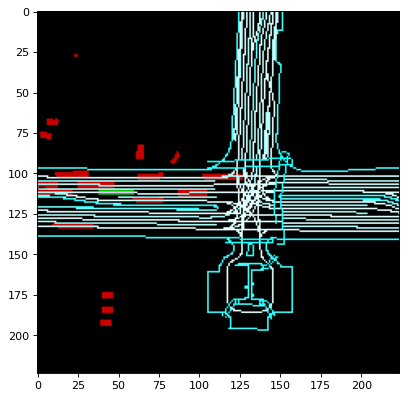

In [124]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.imshow(test_maps[2].permute(1,2,0))

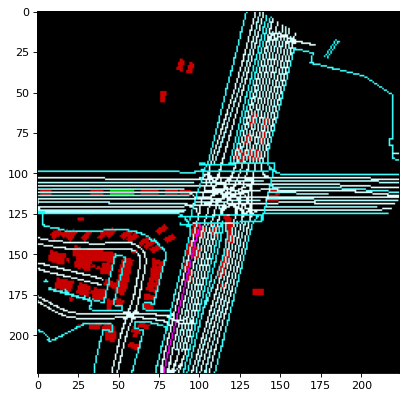

In [125]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.imshow(train_maps[0].permute(1,2,0))
# plt.imshow(train_data["rgbs"][3])

In [58]:
train_maps.std()

tensor(0.3068)

In [62]:
print(train_state_masked.mean())
print(test_state_masked.mean())

tensor(37.6495, device='cuda:0')
tensor(-0.2927, device='cuda:0')


In [147]:
torch.set_printoptions(precision=2, sci_mode=0)
train_data = next(train_iter_loader)
test_data =next(test_iter_loader)
test_batch_unpacked = preprocess_batch(test_data, 0, 0)
train_batch_unpacked = preprocess_batch(train_data, 0, 0)
test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
print("test hist")
print(test_state_masked[:,-1,:2])
print('-'*90)
print("test fut")
print(get_local_fut_path(test_data)[:,-1,:])
print('-'*90)
print('-'*90)
print('-'*90)

print("train")
print("train hist")
print(train_state_masked[:,-1,:2])
print('-'*90)
print("train fut")
print(get_local_fut_path(train_data)[:,-1,:])


test hist
tensor([[    -0.07,     -1.07],
        [    -0.70,    -10.58],
        [    -0.03,     -5.65],
        [    -0.02,     -3.90],
        [    -0.01,     -0.93],
        [     0.02,     -4.96],
        [    -0.01,     -1.79],
        [    -0.18,     -7.94],
        [     0.00,     -0.48],
        [     0.77,     -5.10]], device='cuda:0')
------------------------------------------------------------------------------------------
test fut
tensor([[    51.43,     16.59],
        [ -3530.96,   3059.40],
        [ -3271.56,  -3340.05],
        [    18.97,     33.89],
        [    62.73,     18.62],
        [    -0.00,      4.86],
        [     9.85,     17.71],
        [     0.08,     21.90],
        [  6525.68,    241.02],
        [  5095.19,   4068.17]], device='cuda:0')
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--------------------------------

In [144]:
# test_state_masked[4,:,:2]